<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/vanilla_stein_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm

class SVGD_ll():
    """
    Low-level SVGD implementation from DartML
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)


    def update(self, x0, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[iter] = h

            # adagrad
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad

            theta_all[:, :, iter] = theta
        if return_all:
          return theta_all, lengthscales_all
        else:
          return theta


Example of multivariate normal implemented with above in the DartML code:

In [ ]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A

    def dlnprob_wrong(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1),
                            np.linalg.inv(self.A))

A = np.array([[0.2260,0.1652],[0.1652,0.6779]])
mu = np.array([-0.6871,0.8010])
model = MVN(mu, A)


x0 = np.random.normal(0,1, [200,2])
print(model.dlnprob(x0).shape)
print(SVGD_ll().svgd_kernel(x0)[0].shape)

(200, 2)
(200, 200)


In [ ]:
theta1 = SVGD_ll().update(x0, model.dlnprob, n_iter=500, stepsize=0.01)
print("ground truth: ", mu)
print("svgd: ", np.mean(theta1,axis=0))
print("svgd: ", np.cov(theta1.T))

theta2 = SVGD_ll().update(x0, model.dlnprob_wrong, n_iter=500, stepsize=0.01)
print("ground truth: ", mu)
print("svgd: ", np.mean(theta2,axis=0))
print("svgd: ", np.cov(theta2.T))

ground truth:  [-0.6871  0.801 ]
svgd:  [-0.68895846  0.80205971]
svgd:  [[0.21680716 0.15996021]
 [0.15996021 0.64573378]]
ground truth:  [-0.6871  0.801 ]
svgd:  [-0.68628059  0.8034161 ]
svgd:  [[ 5.14685838 -1.24857702]
 [-1.24857702  1.72546932]]


In [ ]:
import matplotlib.pyplot as plt

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=150,
      #  figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [ ]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=2, scramble=False)
initial_particles = sampler.random(n=100)

# rescale initial points to lie within -1, 1
initial_particles = 2 * initial_particles - 1


/usr/local/lib/python3.10/dist-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [ ]:
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()
    else:
      sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY

# Let us initialize a reusable instance right away.
K = RBF()

(-3.0, 3.0)

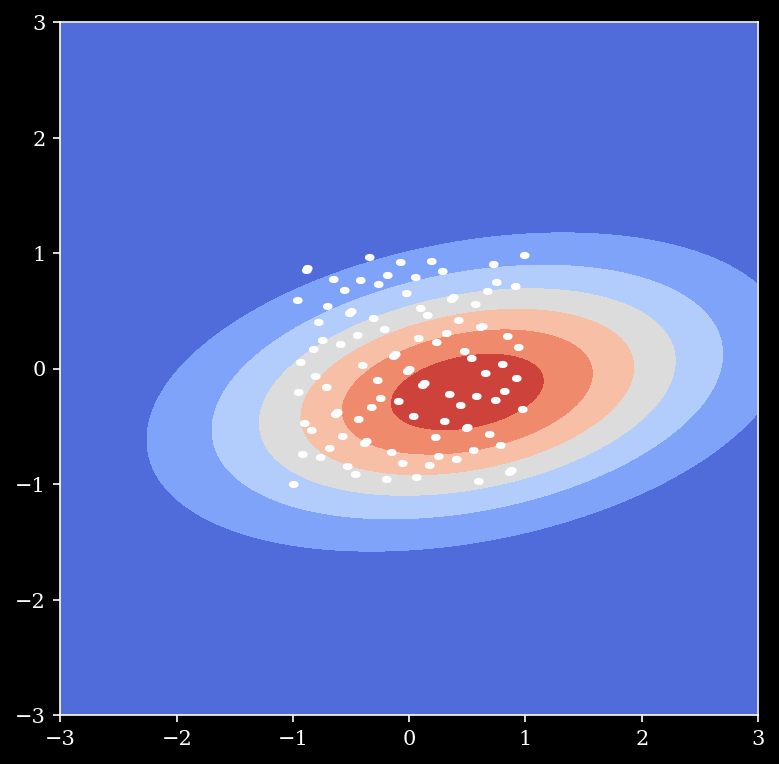

In [ ]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

mu_oracle = np.array([0.5, -0.2])
cov_oracle = np.array([[2.0, 0.3], [0.3, 0.5]])

rv = multivariate_normal(mu_oracle, cov_oracle)


fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(initial_particles[:, 0], initial_particles[:, 1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

In [ ]:
# Expression for dlogprob of multivariate normal (inefficient):
def mvn_dlnprob(theta, mu=mu_oracle, cov=cov_oracle):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))


post_particles_all, lengthscales_all = SVGD_ll().update(initial_particles,
                                                        mvn_dlnprob,
                                                        n_iter=1500,
                                                        stepsize=0.01,
                                                        return_all=True)

In [ ]:
post_particles_all.shape

(100, 2, 1500)

(-3.0, 3.0)

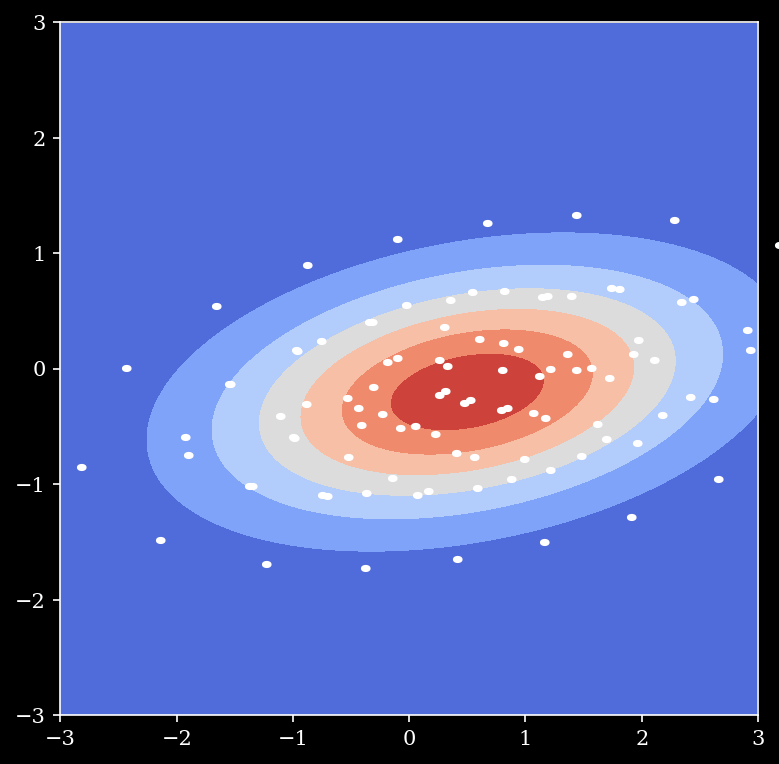

In [ ]:
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(post_particles_all[:, 0, -1], post_particles_all[:, 1, -1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

In [ ]:
lengthscales_all.shape

(1500,)

Text(0, 0.5, 'lengthscale')

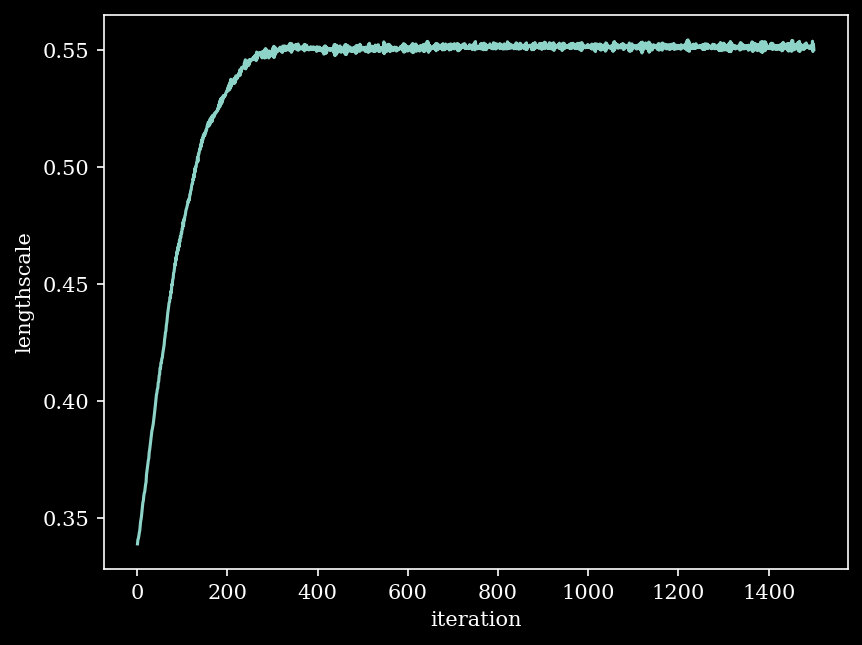

In [ ]:
# plot lengthscales
n_iters = 1500
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all)
plt.xlabel("iteration")
plt.ylabel("lengthscale")

In [ ]:
x02 = np.random.normal(0,1,[3,2])
x02.shape

sq_dist = pdist(x02)
pairwise_dists = squareform(sq_dist)**2
h = np.median(pairwise_dists)
h = np.sqrt(0.5 * h / np.log(x02.shape[0]+1))
Kxy = np.exp( -pairwise_dists / h**2 / 2)
Kxy.shape

(3, 3)

In [ ]:
sq_dist.shape, pairwise_dists.shape

((3,), (3, 3))

In [ ]:
Kxy

array([[1.00000000e+00, 2.50000000e-01, 1.83275328e-46],
       [2.50000000e-01, 1.00000000e+00, 7.19968993e-37],
       [1.83275328e-46, 7.19968993e-37, 1.00000000e+00]])

In [ ]:
dxkxy = -np.matmul(Kxy, x02)
sumkxy = np.sum(Kxy, axis=1)
sumkxy.shape, dxkxy.shape

((3,), (3, 2))

In [ ]:
np.multiply(x02[:, 0], sumkxy)

array([-0.67572739, -1.00557258, -2.89828644])

Torch based implementation examples

In [ ]:
# Low-level RBF:
# def svgd_kernel(self, theta, h = -1):
#     sq_dist = pdist(theta)
#     pairwise_dists = squareform(sq_dist)**2
#     if h < 0: # if h < 0, using median trick
#         h = np.median(pairwise_dists)
#         h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

#     # compute the rbf kernel
#     Kxy = np.exp( -pairwise_dists / h**2 / 2)

#     dxkxy = -np.matmul(Kxy, theta)
#     sumkxy = np.sum(Kxy, axis=1)
#     for i in range(theta.shape[1]):
#         dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
#     dxkxy = dxkxy / (h**2)
#     return (Kxy, dxkxy)

# class RBF(torch.nn.Module):
#   def __init__(self, sigma=None):
#     super(RBF, self).__init__()

#     self.sigma = sigma

#   def forward(self, X, Y):
#     XX = X.matmul(X.t())
#     XY = X.matmul(Y.t())
#     YY = Y.matmul(Y.t())

#     dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

#     # Apply the median heuristic (PyTorch does not give true median)
#     if self.sigma is None:
#       np_dnorm2 = dnorm2.detach().cpu().numpy()
#       h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
#       sigma = np.sqrt(h).item()
#     else:
#       sigma = self.sigma

#     gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
#     K_XY = (-gamma * dnorm2).exp()

#     return K_XY

# # Let us initialize a reusable instance right away.
# K = RBF()

In [ ]:
# import torch
# import torch.autograd as autograd
# import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class SVGD_torch:
#   """
#   Less low level implementation using torch autograd - see https://sanyamkapoor.com/kb/the-stein-gradient/
#   """
#   def __init__(self, P, K, optimizer):
#     self.P = P
#     self.K = K
#     self.optim = optimizer

#   def phi(self, X):
#     X = X.detach().requires_grad_(True)

#     log_prob = self.P.log_prob(X)
#     score_func = autograd.grad(log_prob.sum(), X)[0]

#     K_XX = self.K(X, X.detach())
#     grad_K = -autograd.grad(K_XX.sum(), X)[0]

#     phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

#     return phi


#   def step(self, X):
#     self.optim.zero_grad()
#     X.grad = -self.phi(X)
#     self.optim.step()
#     # save all intermediate Xs


In [ ]:
rv_torch = torch.distributions.MultivariateNormal(torch.Tensor(mu_oracle).to(device),
        covariance_matrix=torch.Tensor(cov_oracle).to(device))

In [ ]:
init_particles_torch = torch.Tensor(initial_particles).to(device)
init_particles_torch.shape

torch.Size([100, 2])

In [77]:
(init_particles_torch[:, None] - init_particles_torch).shape

torch.Size([100, 100, 2])

In [74]:
torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2).shape

torch.Size([100, 100])

In [103]:
torch.sum(torch.isclose(torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2), torch.Tensor(squareform(pdist(initial_particles))))) # nice!!!!!!

tensor(10000)

In [97]:
squareform(pdist(initial_particles))

array([[0.        , 1.41421356, 1.58113883, ..., 1.66257636, 1.75404109,
        1.85786441],
       [1.41421356, 0.        , 0.70710678, ..., 0.27687571, 0.62382702,
        0.87416255],
       [1.58113883, 0.70710678, 0.        , ..., 0.87416255, 0.27687571,
        1.56577781],
       ...,
       [1.66257636, 0.27687571, 0.87416255, ..., 0.        , 0.70710678,
        0.70710678],
       [1.75404109, 0.62382702, 0.27687571, ..., 0.70710678, 0.        ,
        1.41421356],
       [1.85786441, 0.87416255, 1.56577781, ..., 0.70710678, 1.41421356,
        0.        ]])

In [89]:
# torch.nn.PairwiseDistance(p=2)(init_particles_torch, init_particles_torch)

In [ ]:
import torch
import torch.autograd as autograd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SVGD_torch_custom:
  """
  Less low level implementation using torch autograd - see https://sanyamkapoor.com/kb/the-stein-gradient/
  """
  def __init__(self, P, optimizer, ls=None):
    self.P = P
    # self.K = K
    self.optim = optimizer
    if ls is None:
      self.h=-1
    else:
      self.h = nn.Parameter(torch.randn(1))


  def svgd_kernel(self, X1, X2):
    pairwise_dists = torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2)

    # compute lengthscale
    if self.h == -1:
      h = np.median(pairwise_dists)
      h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))
    else:
      h = self.h

    K_XY = torch.exp( -pairwise_dists / h**2 / 2)

    return K_XY, lengthscale


  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX, lengthscale = self.svgd_kernel(X, X.detach())
    grad_K = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()
    # save all intermediate Xs

In [ ]:
!pip install celluloid

In [ ]:
# from celluloid import Camera
# from matplotlib.animation import FuncAnimation

In [ ]:
# jupyter fix?
from IPython.display import HTML
# animation = camera.animate()
# HTML(animation.to_html5_video())

In [ ]:
import os
# os.makedirs("particle_animations", exist_ok=True)

In [ ]:
# from rich.progress import track
# fig = plt.figure(figsize=(6, 6))
# # camera = Camera(fig)
# marker_symbol = u'\u2B2C'

# for i in track(range(post_particles_all.shape[2] + 1), description="Processing particles at step ..."):
#   # Step through and save a few frames only.
#   # for i in range(11):
#   t = plt.contourf(x, y,
#              rv.pdf(pos),
#              cmap='coolwarm')


#   # Scatter initial particles
#   if i == 0:
#     particles_to_show = initial_particles
#   else:
#     particles_to_show = post_particles_all[:, :, i - 1]


#   plt.scatter(particles_to_show[:, 0], particles_to_show[:, 1],
#             color="white",
#             marker="$%s$" % marker_symbol,
#             s=15,
#             clip_on=False)


#   plt.xlim(-3, 3)
#   plt.ylim(-3, 3)

#   plt.savefig(os.path.join("./particle_animations", "particles_iter_{:04d}.png".format(i)), dpi=150)
#   plt.close()

#   camera.snap()

# animation = camera.animate()
# HTML(animation.to_html5_video())
# animation.save('mvn_particles.gif', writer='pillow')

In [ ]:
# from google.colab import files
# import shutil

# shutil.make_archive("particle_animations", 'zip', "particle_animations")
# files.download("particle_animations.zip")

In [ ]:

# from matplotlib import pyplot as plt
# from celluloid import Camera

# fig = plt.figure()
# camera = Camera(fig)
# for i in range(10):
#     plt.plot([i] * 10)
#     camera.snap()
# animation = camera.animate()
# HTML(animation.to_html5_video())

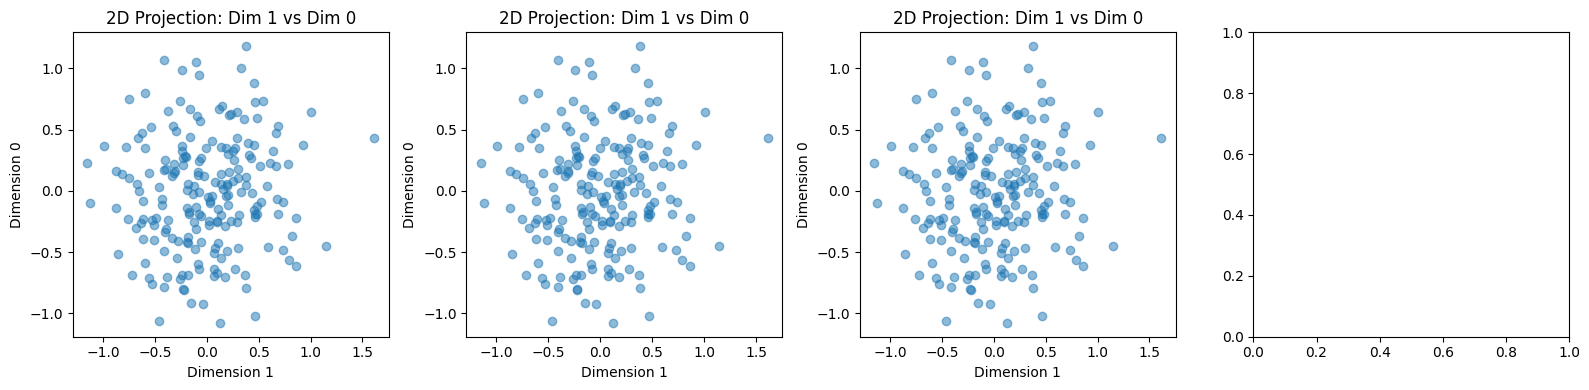

In [ ]:
# Need to fix!

import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dataset iterator
def inf_train_gen(data, rng=None, batch_size=200, n_dim=20):
    if rng is None:
        rng = np.random.RandomState()

    if data == "8gaussians":
        scale = 0.5
        centers = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) + (0,) * (n_dim - 2) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(n_dim) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point += np.array(center)
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset

def plot_8gaussians_projections(data, num_projections=3):
    """
    Plot projections of the multidimensional 8 Gaussians data.

    :param data: numpy array of shape (n_samples, n_dimensions)
    :param num_projections: number of 2D projections to plot
    """
    n_samples, n_dim = data.shape
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # 2D projections
    for i, ax in zip(range(num_projections), axs):
        dim1, dim2 = np.random.choice(n_dim, 2, replace=False)
        # ax = fig.add_subplot(((num_projections + 2) // 3), 3, i+1)
        ax.scatter(data[:, dim1], data[:, dim2], alpha=0.5)
        ax.set_title(f'2D Projection: Dim {dim1} vs Dim {dim2}')
        ax.set_xlabel(f'Dimension {dim1}')
        ax.set_ylabel(f'Dimension {dim2}')

    # 3D projection
    # ax = fig.add_subplot(((num_projections + 2) // 3), 3, num_projections+1, projection='3d')
    if n_dim >= 3:
      dim1, dim2, dim3 = np.random.choice(n_dim, 3, replace=False)
      # change property of ax[-1] to accomodate 3d projection:
      axs[-1] = fig.add_subplot(1, 4, 4, projection='3d')
      axs[-1].scatter(data[:, dim1], data[:, dim2], data[:, dim3], alpha=0.5)
      axs[-1].set_title(f'3D Projection: Dim {dim1} vs Dim {dim2} vs Dim {dim3}')
      axs[-1].set_xlabel(f'Dimension {dim1}')
      axs[-1].set_ylabel(f'Dimension {dim2}')
      axs[-1].set_zlabel(f'Dimension {dim3}')

    plt.tight_layout()
    plt.show()


rng = np.random.RandomState(42)
toy_data = inf_train_gen("8gaussians", rng, batch_size=200, n_dim=2)
plot_8gaussians_projections(toy_data, num_projections=3)

In [ ]:
# Simple way to use Custom Markers (thanks StackOverflow - https://stackoverflow.com/a/15883684)

# from numpy import *
# import matplotlib.pyplot as plt

# symbols = [u'\u2B21',
#            u'\u263A',
#            u'\u29C6',
#            u'\u2B14',
#            u'\u2B1A',
#            u'\u25A6',
#            u'\u229E',
#            u'\u22A0',
#            u'\u22A1',
#            u'\u20DF',
#            u'\u2B2C']

# x = arange(10.)
# y = arange(10.)

# plt.figure()
# for i, symbol in enumerate(symbols):
#     y2 = y + 4*i
#     plt.plot(x, y2, 'g')
#     marker = "$%s$" % symbol
#     print(marker)
#     plt.plot(x, y2, 'k', marker=marker, markersize=30)